# Author : Shubham Mehla

## Stock Market Prediction using Numerical and Textual Analysis

##### GRIP @ The Sparks Foundation

###### In this task i have tries to create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 9
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import lightgbm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
!pip install pmdarima

  Using cached pmdarima-1.8.0-cp38-cp38-win_amd64.whl (616 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0


### Numerical Analysis of ^BSESN stock data

In [65]:
data = pd.read_csv('BSE-100.BO.csv')
#data = data[2:]
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-18,8672.879883,8732.730469,8669.179688,8688.980469,8688.980469,31100.0
1,2017-01-19,8691.719727,8717.549805,8679.200195,8706.700195,8706.700195,33200.0
2,2017-01-20,8689.360352,8701.599609,8605.490234,8612.969727,8612.969727,31200.0
3,2017-01-23,8606.150391,8674.540039,8597.519531,8662.839844,8662.839844,30900.0
4,2017-01-24,8680.839844,8756.209961,8675.780273,8749.780273,8749.780273,30900.0


In [66]:
data.shape

(1028, 7)

In [67]:
num_data = pd.read_csv('BSE-100.BO.csv')
num_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-18,8672.879883,8732.730469,8669.179688,8688.980469,8688.980469,31100.0
1,2017-01-19,8691.719727,8717.549805,8679.200195,8706.700195,8706.700195,33200.0
2,2017-01-20,8689.360352,8701.599609,8605.490234,8612.969727,8612.969727,31200.0
3,2017-01-23,8606.150391,8674.540039,8597.519531,8662.839844,8662.839844,30900.0
4,2017-01-24,8680.839844,8756.209961,8675.780273,8749.780273,8749.780273,30900.0


In [68]:
num_data.shape

(1028, 7)

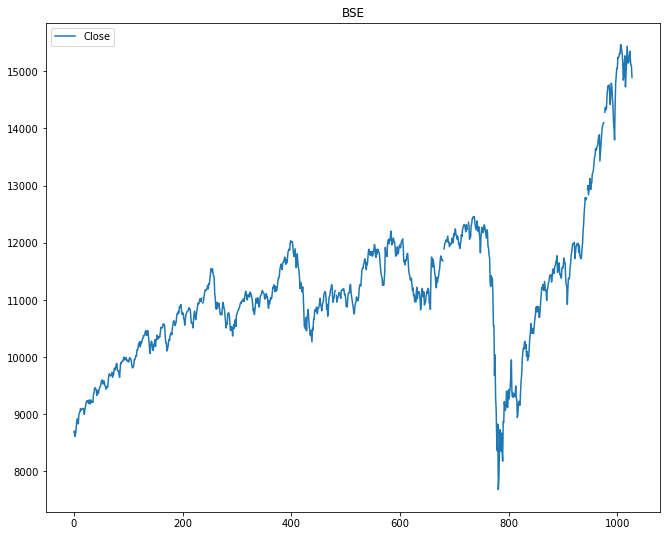

In [69]:
num_data[['Close']].plot()
plt.title("BSE")
plt.show()

In [70]:
num_data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [71]:
# CONVERTING THE DATATYPE OF  DATE COLUMN TO PANDAS DATETIME DATATYPE
num_data['Date'] = pd.to_datetime(num_data['Date'])
num_data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-18,8672.879883,8732.730469,8669.179688,8688.980469,8688.980469,31100.0
1,2017-01-19,8691.719727,8717.549805,8679.200195,8706.700195,8706.700195,33200.0


In [72]:
# NOW THE DATATYPE OF DATE COLUMN IS DATETIME RATHER OBJECT LIKE BEFORE
num_data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [73]:
num_data.isnull().sum(axis =0)

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [74]:
# There are 2 row with null values, so we have to remove them
num_data.dropna(axis = 0, inplace = True)

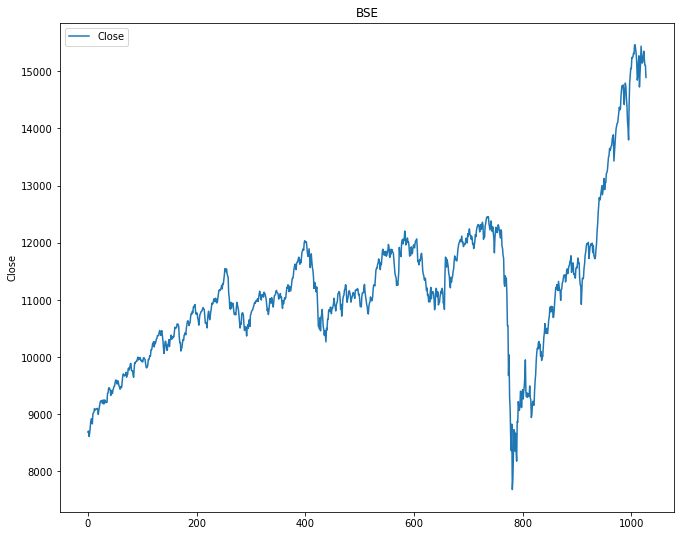

In [75]:
num_data[['Close']].plot()
plt.title("BSE")
plt.ylabel('Close')
plt.show()

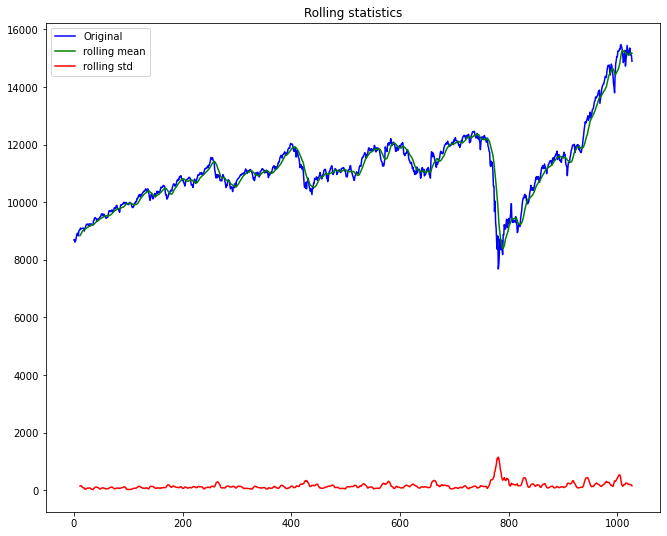

In [76]:
def plot_rolling(data):
    rolmean = data.rolling(window=12).mean()
    rolstd = data.rolling(window=12).std()
    plt.plot(data, color = 'blue', label = 'Original' )
    plt.plot(rolmean, color = 'green', label = 'rolling mean' )
    plt.plot(rolstd, color = 'red', label = 'rolling std' )
    plt.legend(loc = 'best')
    plt.title("Rolling statistics")
    plt.show(block = False)
plot_rolling(num_data['Close'])

In [77]:
# Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
#p_values = {}
def adfuller_test(data):
    dftest = adfuller(data)
    # converting dftest to pandas series
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'P-value','#lags-Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #p_values[data] = dfoutput.iloc[1]
    print(dfoutput)
    print('_-'*60)
    if dfoutput['P-value'] <= 0.05:
        print('Null Hypothesis is wrong, it is stationary')
    else:
        print('Null Hypothesis is correct, it is non-stationary')

adfuller_test(num_data['Close'])

Test Statistic                   -1.195200
P-value                           0.675657
#lags-Used                       11.000000
Number of Observations Used    1010.000000
Critical Value (1%)              -3.436841
Critical Value (5%)              -2.864406
Critical Value (10%)             -2.568296
dtype: float64
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Null Hypothesis is correct, it is non-stationary


<AxesSubplot:>

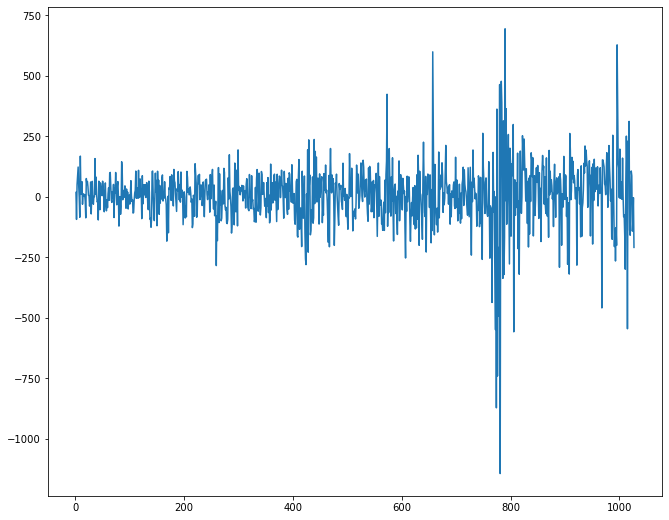

In [78]:
# differencing with lags
#shifted_data = num_data['Close'].shift(1)
data_shift = num_data['Close'] - num_data['Close'].shift(1)
data_shift.dropna(inplace = True)
data_shift.plot()

In [49]:
data_shift.head()

1    453.070313
2    246.320312
3   -334.539062
4     94.988281
5    -38.437500
Name: Close, dtype: float64

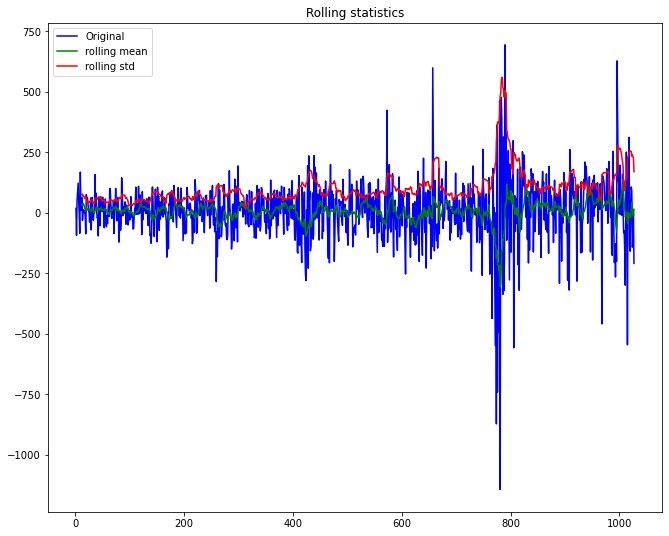

Test Statistic                -8.769734e+00
P-value                        2.540142e-14
#lags-Used                     1.000000e+01
Number of Observations Used    1.010000e+03
Critical Value (1%)           -3.436841e+00
Critical Value (5%)           -2.864406e+00
Critical Value (10%)          -2.568296e+00
dtype: float64
_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
Null Hypothesis is wrong, it is stationary


In [79]:
plot_rolling(data_shift)
adfuller_test(data_shift)

In [80]:
train = data_shift[:650]
test = data_shift[650:]

In [81]:
from pmdarima import auto_arima
model = auto_arima(train, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7568.490, Time=1.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7570.319, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7568.653, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7568.925, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7569.780, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7569.252, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7568.554, Time=0.54 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7572.146, Time=1.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=7572.102, Time=0.94 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7570.410, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=7570.545, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7570.657, Time=0.45 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7571.405, Time=2.12 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7567.848, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]          

Text(0, 0.5, 'Actual Stock Price')

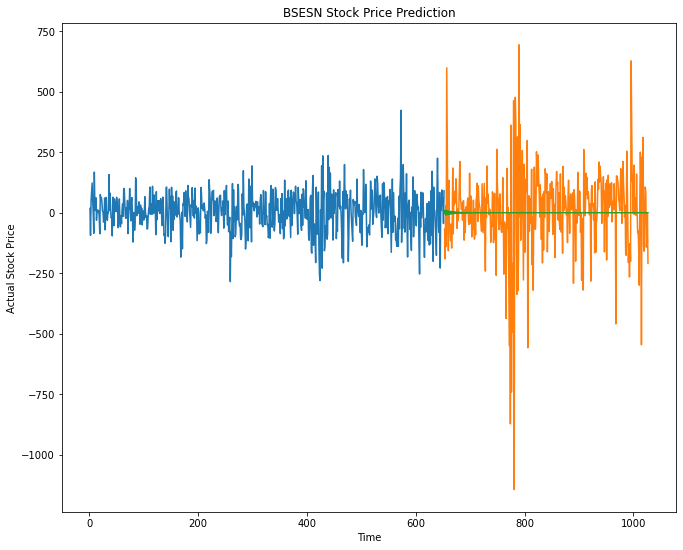

In [82]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [84]:
from sklearn.metrics import mean_squared_error

rms = np.sqrt(mean_squared_error(test,predictions))
print("RMSE : ", rms)

RMSE :  178.4466950551644


## Textual Analysis

In [94]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


In [99]:
columns = ['Date','Category','News']
text_data = pd.read_csv('india-news-headlines.csv', names = columns)
text_data

C:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3424063,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,removed,Govt extends deadline for use of FASTag till F...


In [100]:
text_data.drop(0, inplace=True)
text_data.drop('Category', axis = 1, inplace=True)
text_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [103]:
#Converting data type of Date column 
text_data['Date'] = pd.to_datetime(text_data['Date'],format= '%Y%m%d')
text_data

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-12-31,Govt extends deadline for use of FASTag till F...


In [104]:
#Grouping the headlines for each day
text_data['News'] = text_data.groupby(['Date']).transform(lambda x : ' '.join(x)) 
text_data = text_data.drop_duplicates() 
text_data.reset_index(inplace = True, drop = True)
text_data

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [90]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [109]:
#Adding subjectivity and polarity columns
text_data['Subjectivity'] = text_data['News'].apply(getSubjectivity)
text_data['Polarity'] = text_data['News'].apply(getPolarity)
text_data

<ipython-input-109-2d09c40f6b98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['Subjectivity'] = text_data['News'].apply(getSubjectivity)
<ipython-input-109-2d09c40f6b98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['Polarity'] = text_data['News'].apply(getPolarity)


,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496


<AxesSubplot:>

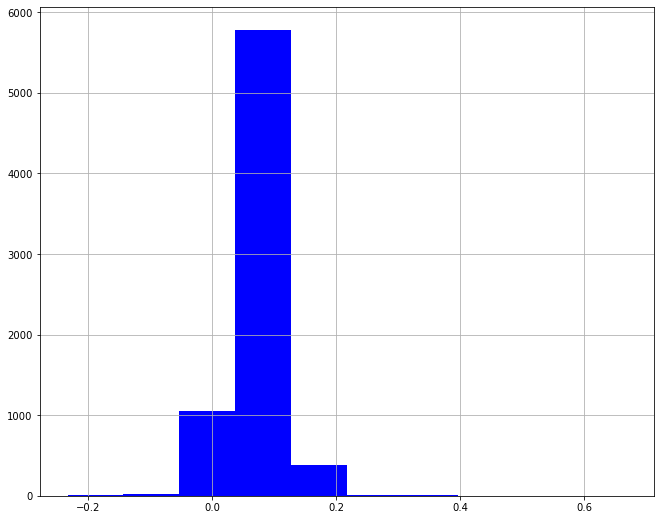

In [111]:
text_data['Polarity'].hist(color = 'blue')


<AxesSubplot:>

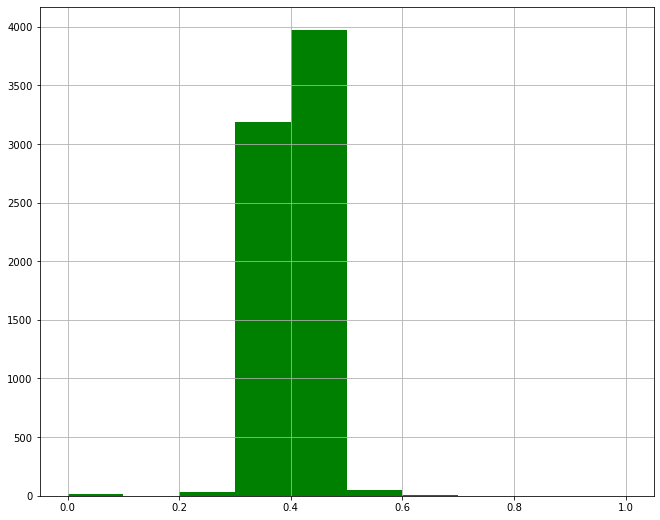

In [112]:
text_data['Subjectivity'].hist(color = 'green')


In [114]:
#Adding sentiment score to text_data
sia = SentimentIntensityAnalyzer()

text_data['Compound'] = [sia.polarity_scores(v)['compound'] for v in text_data['News']]
text_data['Negative'] = [sia.polarity_scores(v)['neg'] for v in text_data['News']]
text_data['Neutral'] = [sia.polarity_scores(v)['neu'] for v in text_data['News']]
text_data['Positive'] = [sia.polarity_scores(v)['pos'] for v in text_data['News']]
text_data

<ipython-input-114-43b25d6d01db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['Compound'] = [sia.polarity_scores(v)['compound'] for v in text_data['News']]
<ipython-input-114-43b25d6d01db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['Negative'] = [sia.polarity_scores(v)['neg'] for v in text_data['News']]
<ipython-input-114-43b25d6d01db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886,-0.9997,0.129,0.793,0.078
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.138,0.768,0.093
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.150,0.754,0.096
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.144,0.775,0.081


## Creating a Hybrid model for Numerical and textual Analysis

In [115]:
merge_data = pd.merge(num_data, text_data, how='inner', on='Date')
merge_data

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2017-01-18,8672.879883,8732.730469,8669.179688,8688.980469,8688.980469,31100.0,Cops bust blackmailing racket; two booked BSF ...,0.422675,0.056263,-0.9998,0.135,0.762,0.103
1,2017-01-19,8691.719727,8717.549805,8679.200195,8706.700195,8706.700195,33200.0,Depression among old worries psychologists Con...,0.353337,0.050092,-0.9998,0.136,0.765,0.099
2,2017-01-20,8689.360352,8701.599609,8605.490234,8612.969727,8612.969727,31200.0,CM Pinarayi Vijayan urges RBI; Nabard to help ...,0.397871,0.085141,-0.9999,0.163,0.725,0.113
3,2017-01-23,8606.150391,8674.540039,8597.519531,8662.839844,8662.839844,30900.0,Are you having 'emotional sex'? 5 ideas to dre...,0.396254,0.052509,-0.9998,0.141,0.755,0.104
4,2017-01-24,8680.839844,8756.209961,8675.780273,8749.780273,8749.780273,30900.0,Arts dean arrested in recruitment scam Ruckus ...,0.413900,0.066684,-0.9999,0.161,0.730,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,2020-12-24,13824.230469,13890.570313,13763.769531,13870.750000,13870.750000,200.0,How to set the mood for sex during cold winter...,0.390942,0.048166,-0.9989,0.094,0.838,0.067
967,2020-12-28,13932.870117,14004.129883,13932.400391,13993.709961,13993.709961,100.0,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.138,0.768,0.093
968,2020-12-29,14037.440430,14085.320313,13970.240234,14046.410156,14046.410156,100.0,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.150,0.754,0.096
969,2020-12-30,14097.690430,14105.599609,13973.959961,14091.870117,14091.870117,100.0,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.144,0.775,0.081


In [116]:
data = merge_data[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,8688.980469,0.422675,0.056263,-0.9998,0.135,0.762,0.103
1,8706.700195,0.353337,0.050092,-0.9998,0.136,0.765,0.099
2,8612.969727,0.397871,0.085141,-0.9999,0.163,0.725,0.113
3,8662.839844,0.396254,0.052509,-0.9998,0.141,0.755,0.104
4,8749.780273,0.413900,0.066684,-0.9999,0.161,0.730,0.109
...,...,...,...,...,...,...,...
966,13870.750000,0.390942,0.048166,-0.9989,0.094,0.838,0.067
967,13993.709961,0.412945,0.070517,-0.9998,0.138,0.768,0.093
968,14046.410156,0.424021,0.061210,-0.9999,0.150,0.754,0.096
969,14091.870117,0.441660,0.043496,-0.9999,0.144,0.775,0.081


In [117]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_data = pd.DataFrame(sc.fit_transform(data))
new_data.columns = data.columns
new_data.index = data.index
new_data.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.156745,0.693728,0.521880,0.00010,0.380952,0.390411,0.588235
1,0.159506,0.159802,0.473338,0.00010,0.388889,0.410959,0.541176
2,0.144900,0.502723,0.749037,0.00005,0.603175,0.136986,0.705882
3,0.152671,0.490277,0.492355,0.00010,0.428571,0.342466,0.600000
4,0.166219,0.626153,0.603855,0.00005,0.587302,0.171233,0.658824


In [118]:
X = new_data.drop('Close', axis=1)
y =new_data['Close']

In [119]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(776, 6)

#### Training a Random Forest Regressor and Adaboost Regressor for hybrid analysis

###### Random Forest Regressor

In [121]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [122]:
# Prediction
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.53896426 0.51779013 0.4361892  0.50553556 0.41070223 0.44844224
 0.44575783 0.50276419 0.49016707 0.50618159]
934    0.723049
279    0.440343
14     0.217642
681    0.674673
458    0.512672
766    0.576053
685    0.690889
966    0.964204
379    0.607627
558    0.652132
Name: Close, dtype: float64
0.02048129713412813


###### Adaboost Regressor

In [123]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [124]:
print(mean_squared_error(predictions, y_test))


0.02025630071925243


###### LGBMRegressor

In [129]:
import lightgbm
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [130]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.023955511050622318


### Conclusion
>> The best model with minimum rms is Adaboost Regressor which is actually the hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

# Thank You !!!
